## IMPORTACIÓN DE LIBRERIAS NECESARIAS ##

In [1]:
import zipfile

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import datetime 

import imageio as iio
import statsmodels.api as sm
from collections import Counter
import re

%matplotlib inline

## EXTRACCIÓN/CARGA DE DATOS 

In [2]:
# Asignamos a una variable la ruta donde se encuentra el archivo zip con el dataset que vamos a trabjar
# Asignamos a otra variable el directorio donde queremos que guarde el dataset extraido de ese archivo zip

path_to_zip_file = '../data/dataset_shark_attack.zip'
directory_to_extract_to = '../data'

In [23]:
# Con esta función de esta libreria importada extraemos el contenido en el zip y lo guardamos en el dorecotrio antes asignado

with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    #zip_ref.extractall(directory_to_extract_to)

In [3]:
# Asiganmos a una nueva variable el contenido del dataset, en este caso un archivo csv
# Guardamos en otra variable los datos decodificados con una función de pandas para empezar a trabjar con ellos en python

path_dataset = '/Users/antoineambros/Documents/proyectos/shark_attacks/data/attacks.csv'
data = pd.read_csv(path_dataset, encoding='latin1')

## EXPLORACIÓN DE DATOS

### Conocer información básica

In [9]:
print('Cantidad de Filas y columnas:',data.shape)

Cantidad de Filas y columnas: (25723, 24)


In [10]:
print(f'COLUMNAS DEL DATASET: {data.columns.values}')

COLUMNAS DEL DATASET: ['Case Number' 'Date' 'Year' 'Type' 'Country' 'Area' 'Location' 'Activity'
 'Name' 'Sex' 'Age' 'Injury' 'Fatal' 'Time' 'Species'
 'Investigator or Source' 'pdf' 'href formula' 'href' 'Case Number.1'
 'Case Number.2' 'original order' 'Unnamed: 22' 'Unnamed: 23']


In [ ]:
# Veamos el tipo de datos. Un vistazo preliminar del contenido del dataset

data.head()

In [5]:
# Aqui podremos ver los tipos de datos que vamos a manejar, si hay muchos datos 'nulos' en el dataset

data.info()

In [4]:
data.isnull().sum()

#### Con la siguiente función vamos a ver cómo son los datos de los que se componen cada una de las variables que tenemos en el DataSet

In [5]:
for i in data.columns:
    print(str(i) + ':' + str(data[i].unique()) + '\n' )

In [6]:
# Mediante esta función podemos ver datos aleatorios de nuestra estructura, y hacernos una idea de lo que tenemos

data.sample(3)

##### Aqui si nos fijamos bien, no todas las columnas están bien escritas, o no aportan nada porque solamente contienen valores NaN, como en el caso de "Unnamed: 22" y "Unnamed: 23",  y eso nos puede llevar a errores mas adelante. Así que vamos a mofificar y eliminar las variables que no nos vayan a hacer falta o no aporten ningún valor al estudio.

In [256]:
# Tenemos dos columnas con un espacio al final y otra con paréntesis, mayúsculas... Vamos a renombrarlas

print('Nombre columnas:',data.columns)

### Arreglamos eso:

In [4]:
data.rename(columns = {'Sex ':'Sex'}, inplace = True)
data.rename(columns = {'Species ':'Species'}, inplace = True)
data.rename(columns = {'Fatal (Y/N)':'Fatal'}, inplace = True)

## Ahora comprobamos los países donde se dan mas casos de ataques de tiburones. El Top 5.

In [10]:
country = data['Country']
Counter(country).most_common(6)

[(nan, 19471),
 ('USA', 2229),
 ('AUSTRALIA', 1338),
 ('SOUTH AFRICA', 579),
 ('PAPUA NEW GUINEA', 134),
 ('NEW ZEALAND', 128)]

In [9]:
country = country.dropna()
top_country = dict(Counter(country).most_common(5))
y_count= (top_country.keys())
x_count= top_country.values()
y_pos_count = np.arange(len(y_count))

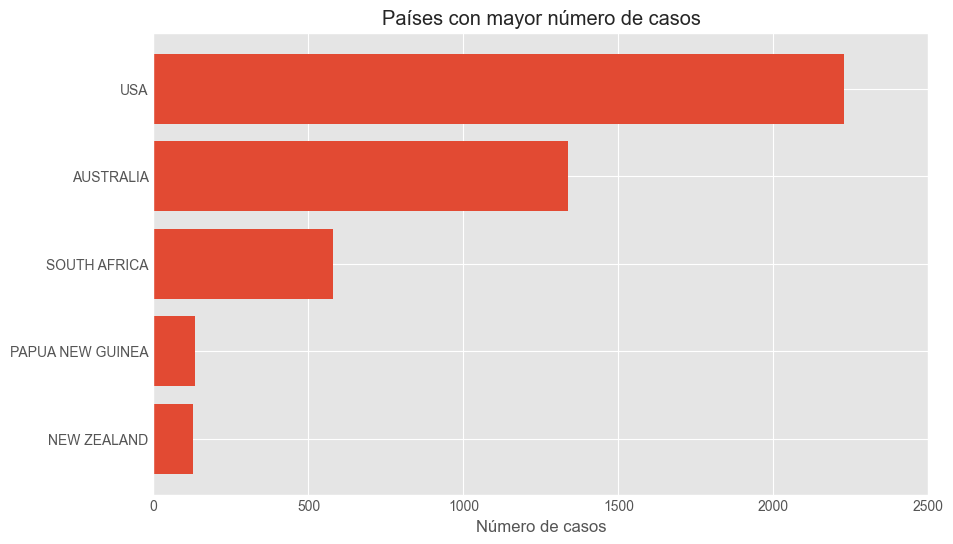

In [34]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [10, 6]
fig, ax = plt.subplots()
ax.barh(y_pos_count, x_count, align='center')
ax.set_yticks(y_pos_count)
ax.set_yticklabels(y_count)
ax.invert_yaxis()  
ax.set_xlabel('Número de casos')
ax.set(xlim=[0, 2500])
ax.set_title('Países con mayor número de casos');

### El País que vamor a centrar nuestro análisis exploratorio será USA

In [5]:
# Vamos a filtrar el dataset por el país con el que nos vamos a quedar para el análisis

country = 'USA'
df_country_filtered = data[data['Country'] == country]

count_num_country_filtered = len(df_country_filtered)
print(f'Los número de registros de ataques de tiburón en {country} son {count_num_country_filtered}')

Los número de registros de ataques de tiburón en USA son 2229


## **Preprocesamiento de datos**

#### Primero vamos a eliminar las variables con las que no vamos a trabajar. Ya sea porque no aportan nada, o porque sólo tienen valores nulos, ect...

##### Borramos las columnas que no nos interesan para el estudio, haciendo una copia para que no perder es dataset original

In [6]:
data_USA = df_country_filtered.copy()

drop_columns = ['Unnamed: 22',
         'Unnamed: 23',
         'Case Number',
         'Name',
         'Investigator or Source',
         'pdf',
         'href formula',
         'href',
         'Case Number.1',
         'Case Number.2',
         'Injury',
         'original order',
         'Time',
         'Location',
         'Area',
         'Type']
         

data_USA.drop(drop_columns, axis=1, inplace=True)

In [37]:
print(f'LAS COLUMNAS QUE AHORA NOS QUEDAN SON: {data_USA.columns}')

LAS COLUMNAS QUE AHORA NOS QUEDAN SON: Index(['Date', 'Year', 'Country', 'Activity', 'Sex', 'Age', 'Fatal',
       'Species'],
      dtype='object')


In [16]:
for i in data_USA.columns:
     print(str(i) + ':' + str(data_USA[i].unique()) + '\n' )

## Limpieza de Nulos

In [7]:
# Aqui vamos ha hacer un conteo de datos nulos en el nuevo dataset con los datos filtrados por el país elegido. USA

data_USA.isnull().sum()

Date          0
Year          0
Country       0
Activity    134
Sex          98
Age         727
Fatal       188
Species     906
dtype: int64

### Vamos a crear una función que nos permita visualizar las columnas que contienen más datos nulos mediante una gráfica

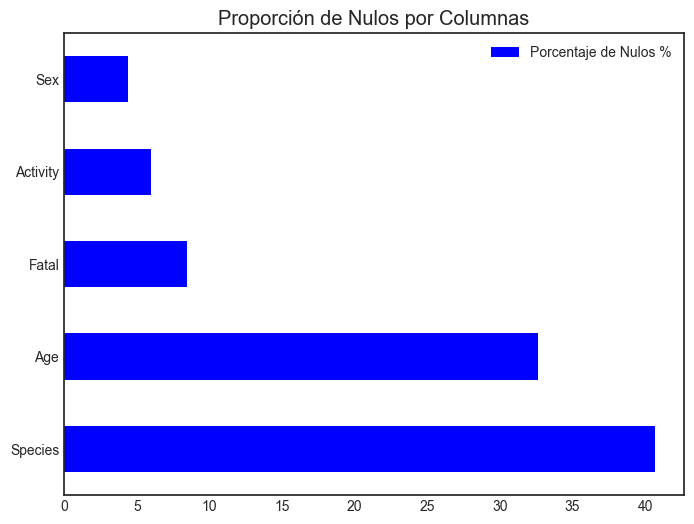

In [39]:
plt.style.use("seaborn-white")

def plot_nas(df: pd.DataFrame):
    if df.isnull().sum().sum() != 0:
        na_df = (df.isnull().sum() / len(df)) * 100      
        na_df = na_df.drop(na_df[na_df == 0].index).sort_values(ascending=False)
        missing_data = pd.DataFrame({'Porcentaje de Nulos %' :na_df})
        missing_data.plot(kind = "barh", title="Proporción de Nulos por Columnas", color='blue', alpha=1., figsize=(8, 6))
        plt.show()
    else:
        print('No Nas found')
plot_nas(data_USA)

#### Ahora vamos a proceder a rellenar esos valores nulos o missing que contienen las variables visualizadas y modificar algunas variables cambiándole el tipo a numérico para poder trabajarlas

In [66]:
data_USA.dtypes

Date         object
Year          int64
Country      object
Activity     object
Sex          object
Age         float64
Fatal        object
Species      object
dtype: object

### Comenzamos con la variable "Date"

In [7]:
def date_convert(date):
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    num_months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
    
    date = str(date)
    if (len(date) == 11 and date[2] == '-'):
        for i in range(len(months)):
            date = date.replace(months[i], num_months[i])
        return date
    else:
        return np.nan

In [8]:
data_USA['Date'] = data_USA['Date'].apply(date_convert)

In [10]:
data_USA = data_USA[~data_USA['Date'].isna()]

### Variable "Year"

In [13]:
def year_covert(year):
    if year > 1945.0: 
        return year
    else:
        return np.nan

In [20]:
data_USA['Year'] = data_USA['Year'].apply(year_covert)

In [16]:
data_USA = data_USA[~data_USA['Year'].isna()]

In [18]:
data_USA = data_USA.astype({'Year':'int'})

### Variable "Sex"

In [21]:
def sex_covert(sex):
    if sex == 'M' or sex == 'F':
        return sex
    else:
        return np.nan

In [22]:
data_USA['Sex'] = data_USA['Sex'].apply(sex_covert)

In [25]:
data_USA[['Sex']].mode()

In [24]:
data_USA['Sex'].fillna('M', inplace=True)

### Variable "Age"

In [28]:
def age_covert(age):
    try:
        age = int(age)
    except ValueError:
        age = 0
        
    if (age > 0 and age <= 100):
        return age
    else:
        return np.nan

In [29]:
data_USA['Age'].fillna(0, inplace=True)

In [30]:
data_USA['Age'] = data_USA['Age'].apply(age_covert)

In [31]:
data_USA['Age'].fillna(data_USA['Age'].mean(), inplace=True)

In [32]:
data_USA = data_USA.astype({'Age':'int'})

### Variable "Fatal"

In [33]:
data_USA = data_USA.replace({'Fatal':{' N':'N','N ':'N'}})

In [34]:
def fatal_convert(fatal):
    if fatal == 'N' or fatal == 'Y':
        return fatal
    else:
        return np.nan

In [35]:
data_USA['Fatal'] = data_USA['Fatal'].apply(fatal_convert)

In [38]:
data_USA[['Fatal']].mode()

In [37]:
data_USA['Fatal'].fillna('N', inplace=True)

### Variable "Activity"

In [41]:
print(data_USA['Activity'].value_counts())

In [42]:
data_USA.loc[data_USA['Activity'].str.contains('surf', case=False, na=False), 'Activity'] = 'Surfing'
data_USA.loc[data_USA['Activity'].str.contains('boarding', case=False, na=False), 'Activity'] = 'Surfing'
data_USA.loc[data_USA['Activity'].str.contains('swim', case=False, na=False), 'Activity'] = 'Swimming'
data_USA.loc[data_USA['Activity'].str.contains('fishing', case=False, na=False), 'Activity'] = 'Fishing'
data_USA.loc[data_USA['Activity'].str.contains('aquarium', case=False, na=False), 'Activity'] = 'Fishing'
data_USA.loc[data_USA['Activity'].str.contains('hunt', case=False, na=False), 'Activity'] = 'Fishing'
data_USA.loc[data_USA['Activity'].str.contains('trap', case=False, na=False), 'Activity'] = 'Fishing'
data_USA.loc[data_USA['Activity'].str.contains('walk', case=False, na=False), 'Activity'] = 'Swimming'
data_USA.loc[data_USA['Activity'].str.contains('wading', case=False, na=False), 'Activity'] = 'Swimming'
data_USA.loc[data_USA['Activity'].str.contains('float', case=False, na=False), 'Activity'] = 'Swimming'
data_USA.loc[data_USA['Activity'].str.contains('Treading water', case=False, na=False), 'Activity'] = 'Swimming'
data_USA.loc[data_USA['Activity'].str.contains('pull', case=False, na=False), 'Activity'] = 'Fishing'
data_USA.loc[data_USA['Activity'].str.contains('pick', case=False, na=False), 'Activity'] = 'Fishing'
data_USA.loc[data_USA['Activity'].str.contains('bath', case=False, na=False), 'Activity'] = 'Swimming'
data_USA.loc[data_USA['Activity'].str.contains('diving', case=False, na=False), 'Activity'] = 'Diving'
data_USA.loc[data_USA['Activity'].str.contains('snorkel', case=False, na=False), 'Activity'] = 'Diving'

In [95]:
data_USA['Activity'].value_counts().head(10)

In [44]:
def activity_convert(activity):
    if activity == 'Surfing' or activity == 'Swimming' or activity == 'Fishing' or activity == 'Diving' or activity == 'Standing' or activity == 'Kayaking' or activity == 'Playing' or activity == 'Jumping' or activity == 'Tagging sharks' or activity == 'Canoeing':
        return activity
    else:
        return np.nan

In [45]:
data_USA['Activity'] = data_USA['Activity'].apply(activity_convert)

In [48]:
data_USA = data_USA[~data_USA['Activity'].isna()]

### Variable "Species"

In [96]:
data_USA['Species'].value_counts().head(5)

In [75]:
def species_convert(species):
    if species == 'Surfing' or species == 'White shark' or species == 'Tiger shark' or species == 'not a shark' or species == 'Blacktip shark' or species == 'Bull shark':
        return species
    else:
        return np.nan

In [90]:
data_USA['Species'] = data_USA['Species'].apply(species_convert)

In [89]:
data_USA['Species'].fillna('White shark', inplace=True)

In [83]:
data_USA = data_USA.replace({'Species':{'not a shark':'Nurse shark'}})

### Ahora podemos comprobar como hemos limpiado los datos de cada una de las columnas, y nos hemos quedado sin ningún valor nulo en todas ellas

In [87]:
data_USA

,Date,Year,Country,Activity,Sex,Age,Fatal,Species
1,18-06-2018,2018,USA,Standing,F,11,N,White shark
2,09-06-2018,2018,USA,Surfing,M,48,N,White shark
7,27-05-2018,2018,USA,Fishing,M,52,N,White shark
8,26-05-2018,2018,USA,Swimming,M,15,N,Bull shark
9,26-05-2018,2018,USA,Standing,M,12,N,White shark
...,...,...,...,...,...,...,...,...
4537,19-09-1948,1948,USA,Swimming,M,27,N,White shark
4538,19-09-1948,1948,USA,Fishing,M,27,N,White shark
4545,01-07-1948,1948,USA,Swimming,M,46,Y,White shark
4570,04-08-1947,1947,USA,Swimming,M,20,Y,White shark


In [88]:
data_USA.isnull().sum()

Date        0
Year        0
Country     0
Activity    0
Sex         0
Age         0
Fatal       0
Species     0
dtype: int64

### Creamos nuestro nuevo DataFrame reseteando los índices, para tenerlo ya con las columnas seleccionadas para nuestro estudio. Ahora ya están filtradas, limpias y corregidos errorer

In [97]:
data_USA = data_USA.reset_index()
data_USA.drop(['index'], axis=1 , inplace=True)

In [98]:
data_USA.isnull().sum()

Date        0
Year        0
Country     0
Activity    0
Sex         0
Age         0
Fatal       0
Species     0
dtype: int64

In [99]:
data_USA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1525 entries, 0 to 1524
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      1525 non-null   object
 1   Year      1525 non-null   int64 
 2   Country   1525 non-null   object
 3   Activity  1525 non-null   object
 4   Sex       1525 non-null   object
 5   Age       1525 non-null   int64 
 6   Fatal     1525 non-null   object
 7   Species   1525 non-null   object
dtypes: int64(2), object(6)
memory usage: 95.4+ KB


In [100]:
data_USA

,Date,Year,Country,Activity,Sex,Age,Fatal,Species
0,18-06-2018,2018,USA,Standing,F,11,N,White shark
1,09-06-2018,2018,USA,Surfing,M,48,N,White shark
2,27-05-2018,2018,USA,Fishing,M,52,N,White shark
3,26-05-2018,2018,USA,Swimming,M,15,N,Bull shark
4,26-05-2018,2018,USA,Standing,M,12,N,White shark
...,...,...,...,...,...,...,...,...
1520,19-09-1948,1948,USA,Swimming,M,27,N,White shark
1521,19-09-1948,1948,USA,Fishing,M,27,N,White shark
1522,01-07-1948,1948,USA,Swimming,M,46,Y,White shark
1523,04-08-1947,1947,USA,Swimming,M,20,Y,White shark


### En este gráfico se muestra la cantidad de ataques de tuburones en USA desde 1945 hasta 2018.

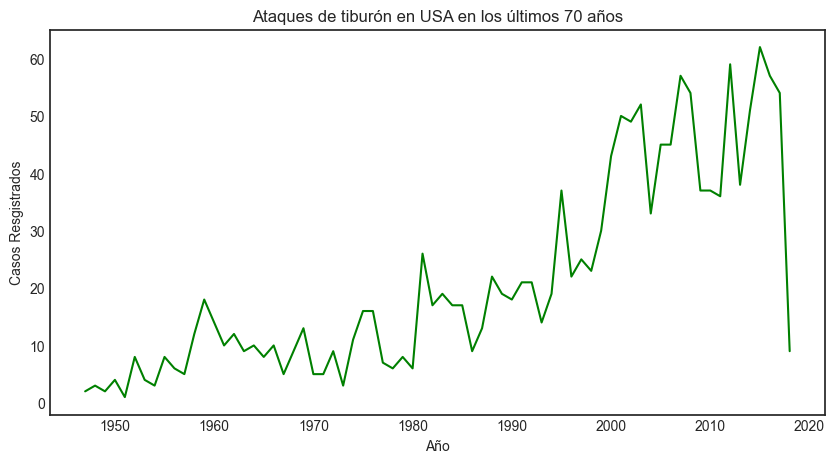

In [111]:
year_attack = data_USA[data_USA['Year'] >= 1945]

year_attack = year_attack.groupby('Year')['Date'].count().reset_index()

plt.style.use("seaborn-white")
year_attack.plot(kind='line', x= "Year", y= "Date", title= "Ataques de tiburón en USA en los últimos 70 años", legend=False, linestyle='-', color='g', figsize=(10, 5))
plt.xlabel('Año')
plt.ylabel('Casos Resgistrados')

plt.show()

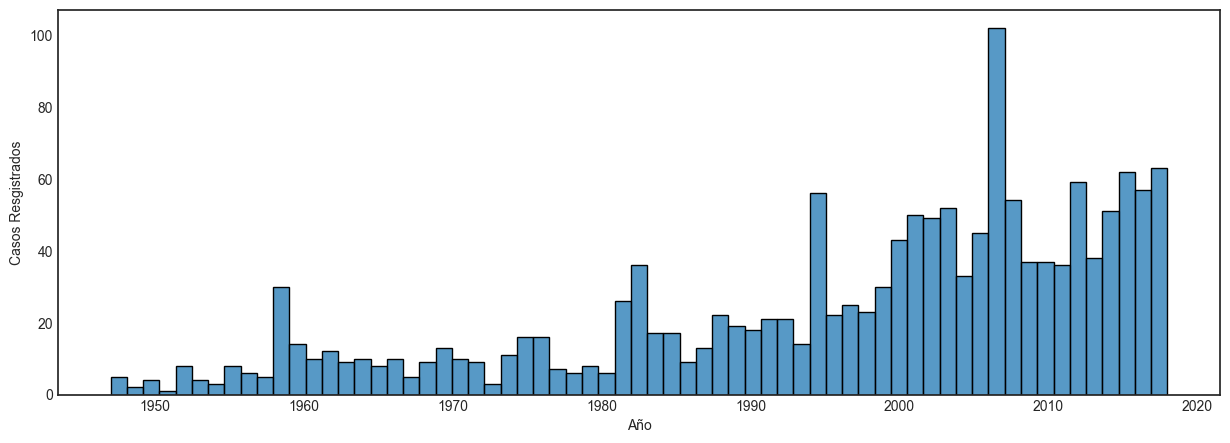

In [116]:
plt.figure(figsize = (15,5))
sns.histplot(data=data_USA, x="Year", bins=65)
plt.xlabel('Año')
plt.ylabel('Casos Resgistrados')
plt.show()

### Aqui vamos a mostrar los ataques registrados en USA entre 2002 y 2018, siendo este último año, del último que se tienen registros

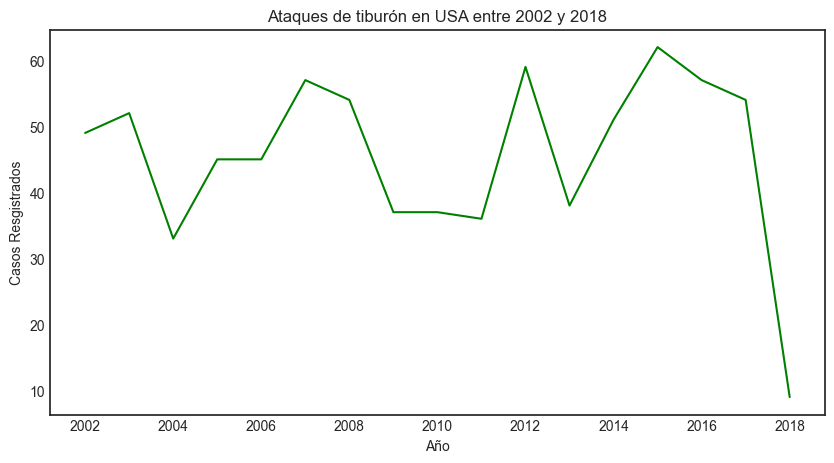

In [121]:
year_attack2 = data_USA[data_USA['Year'] >= 2002]

year_attack2 = year_attack2.groupby('Year')['Date'].count().reset_index()
plt.style.use("seaborn-white")
year_attack2.plot(kind='line', x= "Year", y= "Date", title= "Ataques de tiburón en USA entre 2002 y 2018", legend=False, linestyle='-', color='g', figsize=(10, 5))
plt.xlabel('Año')
plt.ylabel('Casos Resgistrados')

plt.show()

### TOP TEN AÑOS CON MÁS ATAQUES

In [122]:
dates = pd.to_datetime(data_USA['Date'],dayfirst=True, errors='coerce')

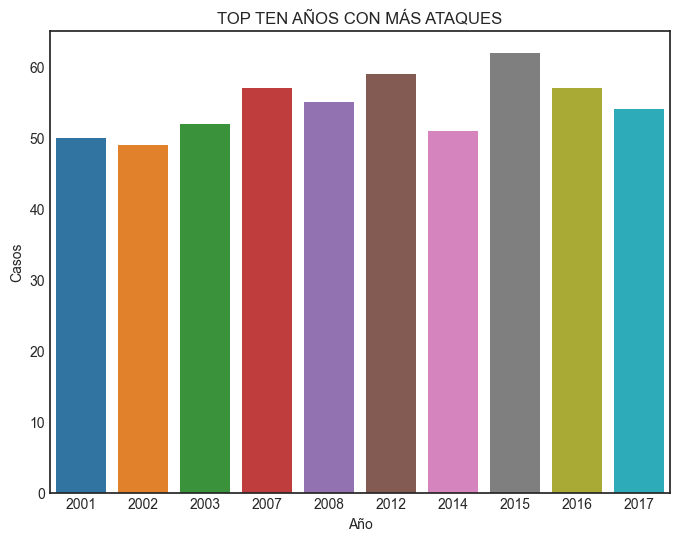

In [127]:
year = dates.dropna().map(lambda x:x.year)
year_counter = Counter(year).most_common(10)
year_index = [year[0] for year in year_counter]
year_values = [year[1] for year in year_counter]

fig,ax = plt.subplots(figsize=(8,6))
sns.barplot(x = year_index,y=year_values,ax=ax)
plt.title('TOP TEN AÑOS CON MÁS ATAQUES')
plt.xlabel('Año')
plt.ylabel('Casos')
plt.show();

## Visualización de ataques de tiburón en USA según el género

In [265]:
data_USA['Sex'].value_counts()

In [78]:
data_USA.loc[data_USA['Sex'].str.contains("M"), 'Sex'] = "Hombres"

In [79]:
data_USA.loc[data_USA['Sex'].str.contains("F"), 'Sex'] = "Mujeres"

In [266]:
Sex_count = data_USA['Sex'].value_counts().reset_index().rename(columns={'index':'Gender','Sex':'Count'})

Sex_count

## Gráfica sobre la Propoción de Hombres, Mujeres y Sin Especificar, de casos de ataques de tiburones en USA.

In [189]:
fig = px.pie(data_frame = Sex_count,
             values = 'Count',
             names = 'Gender',
             title = 'Ataques de Tiburón por Género en USA',
             color_discrete_sequence=px.colors.qualitative.Set2
             )

In [190]:
fig.update_traces(textposition ='outside',
                  textinfo = 'label+percent')
fig.update_layout(paper_bgcolor='moccasin',
                  legend_title = 'Género',
                  font = dict(
                      family = "Helvetica",
                      size = 18,
                      color = 'black'
                  ))

fig.show()

## Vamos a mostrar ahora las proporciones de muertes y de supervivientes a los ataques por tiburones en USA

In [267]:
data_USA['Fatal'].value_counts()

In [130]:
data_USA.loc[data_USA['Fatal'] == "N", 'Fatal'] = 'NO'

In [131]:
data_USA.loc[data_USA['Fatal'] == "Y", 'Fatal'] = 'SI'

In [268]:
Fatal_count = data_USA['Fatal'].value_counts().reset_index().rename(columns = {'Fatal':'Count','index':'Status'})
Fatal_count

In [210]:
fig2 = px.pie(data_frame = Fatal_count,
             values = 'Count',
             names = 'Status',
             title = '¿Sobrevivió?',
             color_discrete_sequence=px.colors.qualitative.Set1
             )

In [211]:
fig2.update_traces(textposition ='outside',
                  textinfo = 'label+percent')
fig2.update_layout(paper_bgcolor='navajowhite',
                  legend_title = 'Estado',
                  font = dict(
                      family = "Helvetica",
                      size = 18,
                      color = 'black'
                  ))

fig2.show()

## Aqui vamos a ver de forma gráfica el TOP 5 de los tiburones que más ataques han provocado en USA

In [269]:
data_USA['Species'].value_counts()

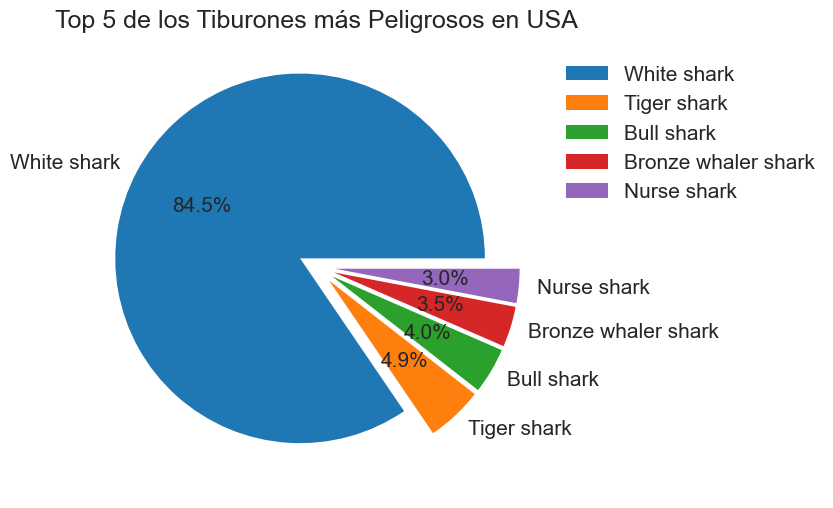

In [270]:
shark5 = data_USA.groupby(['Species'], as_index=False).size()

shark5 = shark5.sort_values(by=['size'], ascending=False)

shark5 = shark5[0:5]

mlabels=['White shark','Tiger shark','Bull shark','Bronze whaler shark', 'Nurse shark']

plt.pie(shark5['size'],labels=mlabels, explode = (0.1,0.1,0.1,0.1,0.1), autopct='%1.1f%%')

plt.title('Top 5 de los Tiburones más Peligrosos en USA', loc='center')

fig = plt.gcf()

fig.set_size_inches(8,6)

plt.legend(bbox_to_anchor=(1,0.6), loc="lower left")

plt.show()
                          